# Calibration of a line to data comparing approaches to dealing with systematic error

In [1]:
import rxmc

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [2]:
from collections import OrderedDict

import corner
import matplotlib.patches as mpatches
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

## make the model

In [3]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

    def y(self, x, m, b):
        # useful to have a function hat takes in an array-like x
        # rather than an Observation, e.g. for plotting
        return m * x + b

In [4]:
my_model = LinearModel()

## set up prior

In [5]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 0.3),
        ("b", 1),
    ]
)

In [6]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))

In [7]:
n_prior_samples = 100000
prior_distribution = stats.multivariate_normal(mean, covariance)
prior_samples = prior_distribution.rvs(size=n_prior_samples)

Let's plot some samples of lines from this prior

In [8]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 1),
        ("b", 1),
    ]
)

In [9]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))

In [10]:
n_prior_samples = 100000
prior_distribution = stats.multivariate_normal(mean, covariance)
prior_samples = prior_distribution.rvs(size=n_prior_samples)

## find observations to calibrate to
Compared to the previous demo, we will include a systematic error due to normalization in our synthetic data. 

In [11]:
true_params = OrderedDict(
    [
        ("m", 0.6),
        ("b", 2),
    ]
)

In [12]:
rng = np.random.default_rng(13)

In [13]:
systematic_fractional_err = 0.07
# choose a normalization 1 std deviation below the mean
N = 1 - systematic_fractional_err
noise = 0.05
x = np.linspace(0.01, 1.0, 10, dtype=float)
y_stat_err = noise * np.ones_like(x) * N  # noise is just a constant fraction of y
y_true = my_model.y(x, *list(true_params.values()))
y_exp = (y_true + rng.normal(scale=noise, size=len(x))) * N

Text(0.5, 1.0, 'experimental constraint with bias')

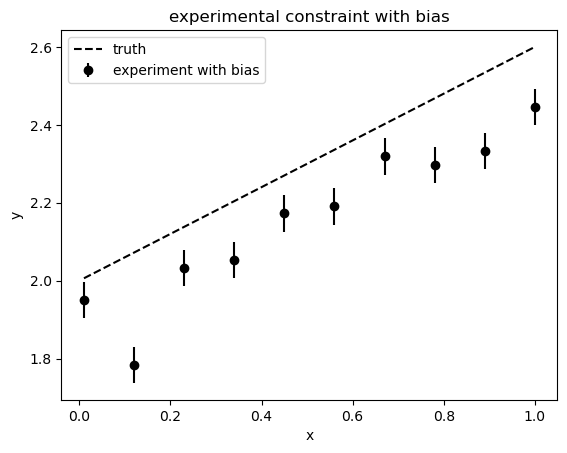

In [14]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x, y_true, "k--", label="truth")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("experimental constraint with bias")

## Compare Likelihood Models
We will look at a few different cases:
1. Covariance is fixed to just statistical error (disregarding systematic error)

   \begin{equation}
       \Sigma_{ij} = \delta_{ij} \sigma_{stat,i}^2
   \end{equation}

3. Covariance is just statistical error, but we fit the magnitude of the statistical noise $\eta$ (disregarding systematic error). This means the covariance is not fixed, but will be updated during calibration.

   \begin{equation}
       \Sigma_{ij} = \delta_{ij} \eta^2
   \end{equation}


5. Systematic error is included properly in covariance, making the covariance a function of the model prediction. Again, this means the covariance is not fixed, but will be updated during calibration.

    \begin{equation}
       \Sigma_{ij}(\alpha) = \delta_{ij} \sigma_{stat,i}^2 + \sigma_N^2 y_m(x_i; \alpha) y_m(x_j; \alpha)
   \end{equation}

7. Systematic error is included improperly in covariance, using the experimental $y(x_i)$ instead of the model prediction $y_m(x_i;\alpha)$. In this case the covariance is again fixed.

    \begin{equation}
       \Sigma_{ij} = \delta_{ij} \sigma_{stat,i}^2 + \sigma_N^2 y(x_i) y(x_j)
   \end{equation}


In [15]:
# 1 and 2
obs_stat_only = rxmc.observation.FixedCovarianceObservation(
    x=x,
    y=y_exp,
    covariance=np.diag(y_stat_err**2),
)

# 3
obs_sys_norm_correct = rxmc.observation.Observation(
    x=x,
    y=y_exp,
    y_stat_err=y_stat_err,
    y_sys_err_normalization=systematic_fractional_err,
)

# 4
obs_sys_norm_wrong = rxmc.observation.FixedCovarianceObservation(
    x=x,
    y=y_exp,
    covariance=np.diag(y_stat_err**2)
    + systematic_fractional_err**2 * np.outer(y_exp, y_exp),
)

## set up likelihood models and constraints

In [16]:
# 1 and 4
likelihood_fixed_cov = rxmc.likelihood_model.FixedCovarianceLikelihood()

# 2
likelihood_unknown_stat = rxmc.likelihood_model.UnknownNoiseErrorModel()

# 3
likelihood_sys_correct = rxmc.likelihood_model.LikelihoodWithSystematicError()

In [17]:
# 1
constraint_stat_only = rxmc.constraint.Constraint(
    [obs_stat_only],
    my_model,
    likelihood_fixed_cov,
)

# 2
constraint_unknown_stat = rxmc.constraint.Constraint(
    [obs_stat_only],
    my_model,
    likelihood_unknown_stat,
)

# 3
constraint_sys_correct = rxmc.constraint.Constraint(
    [obs_sys_norm_correct],
    my_model,
    likelihood_sys_correct,
)

# 4
constraint_sys_wrong = rxmc.constraint.Constraint(
    [obs_sys_norm_wrong],
    my_model,
    likelihood_fixed_cov,
)

## Run option 1: fixed covariance, statistical error only

In [18]:
%%time
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution,
    rxmc.corpus.Corpus([constraint_stat_only]),
    nsteps=10000,
    burnin=1000,
    verbose=True,
)

ValueError: If likelihood_starting_point is provided, likelihood_prior must also be provided.

In [19]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${my_model.params[i].latex_name}$ [{my_model.params[i].unit}]")
    true_value = true_params[my_model.params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

NameError: name 'chain' is not defined

In [ ]:
posterior_range = np.vstack([np.min(chain, axis=0), np.max(chain, axis=0)]).T

In [ ]:
fig = corner.corner(
    chain,
    labels=[p.name for p in my_model.params],
    label="posterior",
    truths=[true_params["m"], true_params["b"]],
)
fig.suptitle("posterior")

In [ ]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model.y(x, *sample)

upper, lower = np.percentile(y, [5, 95], axis=0)

In [ ]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x, y_true, "k--", label="truth")
plt.fill_between(
    x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("statistical error only")

## Run option 2: unknown statistical error

In [ ]:
noise_prior = stats.norm(loc=noise, scale=noise/10)
print(f"mean: {noise_prior.mean():1.2f} std: {noise_prior.std():1.2}")

In [ ]:
def noise_proposal(x):
    return stats.norm.rvs(loc=x, scale=noise/100)

In [ ]:
%%time
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution,
    rxmc.corpus.Corpus([constraint_sys_correct]),
    nsteps=10000,
    burnin=1000,
    verbose=True,
)

## Run option 3: correct formulation of the systematic error

In [ ]:
%%time
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution,
    rxmc.corpus.Corpus([constraint_sys_correct]),
    nsteps=10000,
    burnin=1000,
    verbose=True,
)

In [ ]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${my_model.params[i].latex_name}$ [{my_model.params[i].unit}]")
    true_value = true_params[my_model.params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

In [ ]:
posterior_range = np.vstack([np.min(chain, axis=0), np.max(chain, axis=0)]).T

In [ ]:
fig = corner.corner(
    chain,
    labels=[p.name for p in my_model.params],
    label="posterior",
    truths=[true_params["m"], true_params["b"]],
)
fig.suptitle("posterior")

In [ ]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model.y(x, *sample)

upper, lower = np.percentile(y, [5, 95], axis=0)

In [ ]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x, y_true, "k--", label="truth")
plt.fill_between(
    x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Correct systematic error")

## run option 4: fixed covariance with wrong systematic error

In [ ]:
%%time
logl, chain, accepted_frac = rxmc.mcmc.run_chain(
    prior_distribution,
    rxmc.corpus.Corpus([constraint_sys_wrong]),
    nsteps=10000,
    burnin=1000,
    verbose=True,
)

In [ ]:
fig, axes = plt.subplots(chain.shape[1] + 1, 1, figsize=(8, 8), sharex=True)
for i in range(chain.shape[1]):
    axes[i].plot(chain[:, i])
    axes[i].set_ylabel(f"${my_model.params[i].latex_name}$ [{my_model.params[i].unit}]")
    true_value = true_params[my_model.params[i].name]
    axes[i].hlines(true_value, 0, len(chain), "r", linestyle="--")


axes[-1].plot(logl)
axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

axes[-1].set_xlabel(r"$i$")
# plt.legend(title="chains", ncol=3,)

In [ ]:
posterior_range = np.vstack([np.min(chain, axis=0), np.max(chain, axis=0)]).T

In [ ]:
fig = corner.corner(
    chain,
    labels=[p.name for p in my_model.params],
    label="posterior",
    truths=[true_params["m"], true_params["b"]],
)
fig.suptitle("posterior")

In [ ]:
n_posterior_samples = chain.shape[0]
y = np.zeros((n_posterior_samples, len(x)))
for i in range(n_posterior_samples):
    sample = chain[i, :]
    y[i, :] = my_model.y(x, *sample)

upper, lower = np.percentile(y, [5, 95], axis=0)

In [ ]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x, y_true, "k--", label="truth")
plt.fill_between(
    x,
    lower,
    upper,
    alpha=0.5,
    zorder=2,
    label=r"posterior inner 90$^\text{th}$ pctl",
)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Incorrect systematic error")

# Multiple constraints
Let's add a second constraint and see how these models compare.

In [ ]:
systematic_fractional_err2 = 0.07
# choose a normalization 1 std deviation above the mean
N2 = 1 + systematic_fractional_err2
noise2 = 0.05
x2 = np.linspace(0.7, 1.5, 30, dtype=float)
y_stat_err2 = noise2 * np.ones_like(x2) * N2  # noise is just a constant fraction of y
y_true2 = my_model.y(x2, *list(true_params.values()))
y_exp2 = (y_true2 + rng.normal(scale=noise2, size=len(x2))) * N2

In [ ]:
fullx = np.linspace(0,1.6,10)
ytrue_full = my_model.y(fullx, *list(true_params.values()))

In [ ]:
plt.errorbar(
    x,
    y_exp,
    y_stat_err,
    marker="o",
    linestyle="none",
    label="observation 1",
)
plt.errorbar(
    x2,
    y_exp2,
    y_stat_err2,
    marker="o",
    linestyle="none",
    label="observation 2",
)

plt.plot(fullx, ytrue_full, "k--", label="truth")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("multiple constraint with normalization error")

In [ ]:
# 1 and 2
obs_stat_only2 = rxmc.observation.FixedCovarianceObservation(
    x=x2,
    y=y_exp2,
    covariance=np.diag(y_stat_err2**2),
)

# 3
obs_sys_norm_correct = rxmc.observation.Observation(
    x=x2,
    y=y_exp2,
    y_stat_err=y_stat_err2,
    y_sys_err_normalization=systematic_fractional_err2,
)

# 4
obs_sys_norm_wrong = rxmc.observation.FixedCovarianceObservation(
    x=x2,
    y=y_exp2,
    covariance=np.diag(y_stat_err2**2)
    + systematic_fractional_err2**2 * np.outer(y_exp2, y_exp2),
)